In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import rc
plt.style.use('classic')
rc('font', **{'family': 'DejaVu Sans', 'serif': ['Computer Modern'], 'size':15})
rc('figure', facecolor='w')
import astropy.io.fits as fits
from astropy.io import ascii
import math, os

from calibration import emission, centroid, linear_regression

#optional dependencies
from distutils.spawn import find_executable
if find_executable('latex'): rc('text', usetex=True)
else: rc('text', usetex=False)

In [3]:
arc = np.load('spectra/kast_1D/arclamp_spectra.npy')
# arc[np.where(arc == np.Inf)[0]] = np.nan
arc = arc[0:2048]
data = np.array([np.arange(1,len(arc)+1), arc])

In [48]:
len(arc)

2048

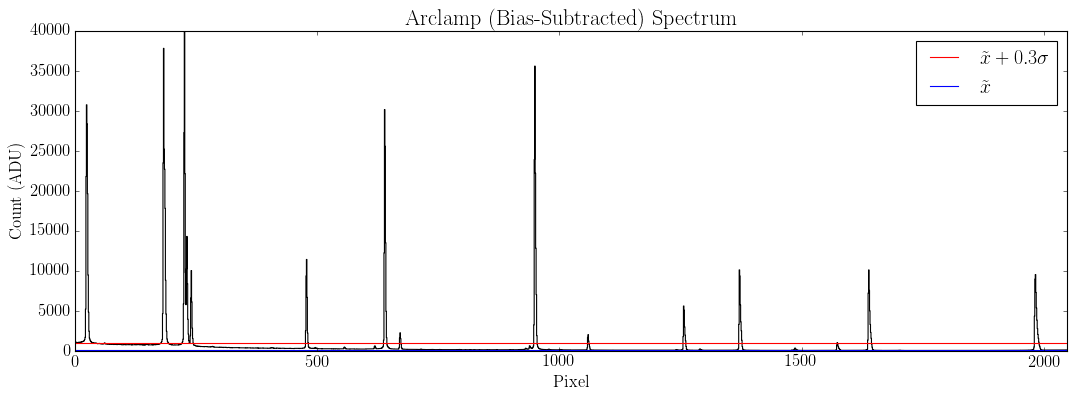

In [4]:
emiss = emission(data, thres=.3, ylim=[0,40000], title='Arclamp (Bias-Subtracted) Spectrum', \
                 save='writeup/plots/kast_arclamp_thres.png')

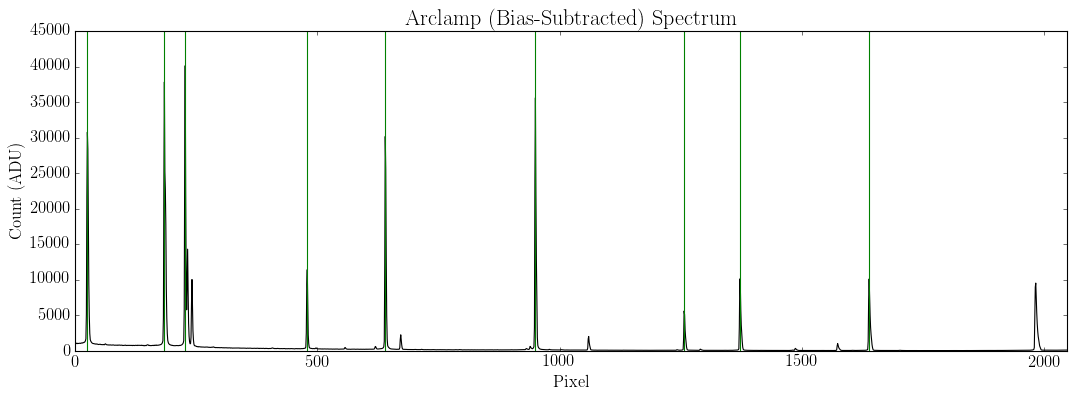

In [5]:
cent = centroid(data, emiss, xlim=[0,2048], title='Arclamp (Bias-Subtracted) Spectrum', \
               save='writeup/plots/kast_arclamp_centroids.png')

In [6]:
# for c in cent:
#     print(data[1][c])

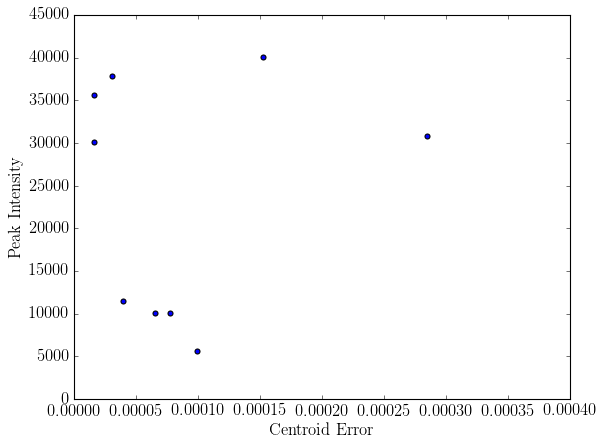

In [7]:
#Produces float values for the centroids, calculating their error and width
centroids, errors, widths, intensities = [], [], [], []
for i in np.arange(len(cent)):
    inte = []
    for a in emiss[i]:
        inte.append(data[1][a])
    centr_f = sum(emiss[i]*inte)/sum(inte)
    err_f = sum(inte*((emiss[i]-centr_f)**2))/(sum(inte))**2
    width_f = sum(inte*((emiss[i]-centr_f)**2))/sum(inte)
    
    centroids.append(centr_f)
    errors.append(err_f)
    widths.append(width_f)
    intensities.append(max(data[1][emiss[i]]))
    
plt.scatter(errors, intensities)
plt.xlim(0, .0004)
plt.xlabel('Centroid Error')
plt.ylabel('Peak Intensity')
plt.savefig('writeup/plots/kast_error_vs_intensity.png')
plt.show()

In [10]:
cal = pd.read_csv('wavecal/kast_HeHgCd.csv')

arr = np.array([np.array(cal['spec_pixel']), np.array(cal['ref_wave'])])

[m,c], [m_err, c_err] = linear_regression(arr[0], arr[1])
print(m,c)
print(m_err, c_err)

1.5487513272669329 3292.523519928771
1.2564978548278467e-15 1.167903607352315e-12


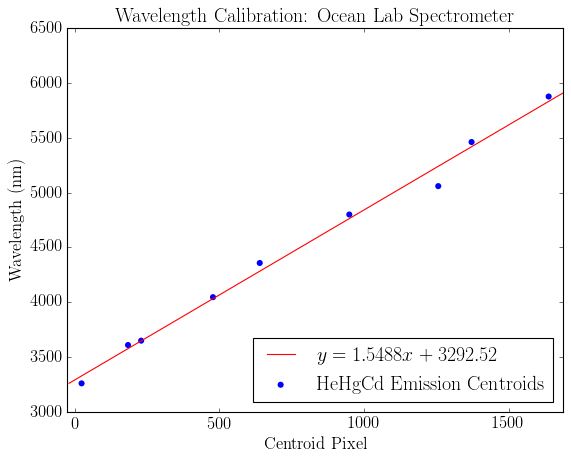

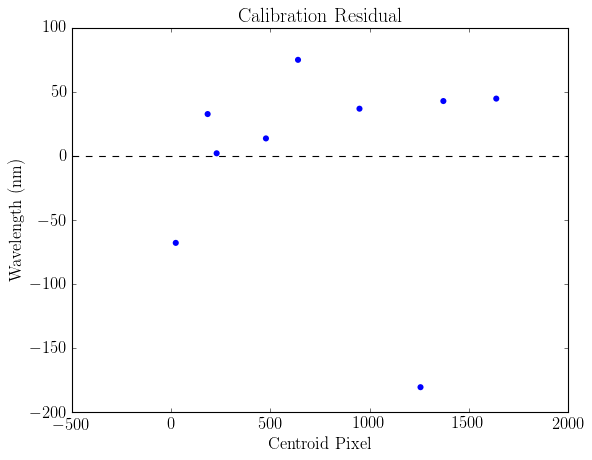

In [17]:
#==============
#Plot wavelength fit

xarr = np.arange(-20,2000)
yarr = m*xarr + c

plt.scatter(arr[0], arr[1], color='b', edgecolor='none', s=30, label='HeHgCd Emission Centroids')
plt.plot(xarr, yarr, color='r', label='$y=%s x + %s$'%(np.round(m,4), np.round(c,2)))

plt.xlim(arr[0][0]-50, arr[0][-1]+50)
plt.ylim(3000,6500)
plt.xlabel('Centroid Pixel')
plt.ylabel('Wavelength (nm)')
plt.title('Wavelength Calibration: Ocean Lab Spectrometer')
plt.legend(loc='lower right', scatterpoints=1)
plt.savefig('writeup/plots/kast_wavecal.png')
plt.show()

#==============
#Plot residuals
fit = m*arr[0] + c

plt.scatter(arr[0], arr[1] - fit, color='b', edgecolor='none', s=30)
plt.axhline(0, linestyle='--', color='k')
plt.xlabel('Centroid Pixel')
plt.ylabel('Wavelength (nm)')
plt.title('Calibration Residual')
plt.savefig('writeup/plots/kast_residual.png')
plt.show()

In [19]:
hdf = fits.open('/home/jess/Desktop/Academic/PHYS164/lab2/spectra/kast_raw/b100.fits')